In [3]:
import math
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
from scipy.stats import norm

In [224]:
def get_sigm(t):
    if t<=1/12:
        return 0.12
    elif t<=1/4:
        return 0.13
    elif t<=5/12:
        return 0.15
    else:
        return 0.17

    
def get_sigms2(T, N):
    dt = T/N
    sigms = []
    for i in range(N):
        t = i*dt
        sigm = get_sigm(t)
        sigms.append(sigm)
    sigms = np.array(sigms)
    sigms2 = sigms**2
    return sigms2


def get_vol(i, sigms2, T, N):
    dt = T/N
    sub_sigms2 = sigms2[i:]*dt
    vol = 1/(T-i*dt)*np.sum(sub_sigms2)
    vol = vol**0.5
    return vol


def St_simulation_SDE(S0, T, N, r):
    dt = T/N
    dBs = np.random.normal(0, dt**0.5, N)
    path = []
    St = S0
    path.append(St)
    for i,dB_i in enumerate(dBs):
        sigm_i = get_sigm(i*T/N)
        St = St + sigm_i*St*dB_i+r*St*dt
        path.append(St)
    return path


def continous_value(path, Deltas, Ct_path, r, T, N):
    dt = T/N
    Vs = []
    v_i = Ct_path[0]
    Vs = [v_i]
    R = math.exp(r*dt)
    for i, delta in enumerate(Deltas):
        St_plus = path[i+1]
        St = path[i]
        Ct = Ct_path[i]
        v_i = v_i*R+delta*(St_plus-St*R)
        Vs.append(v_i)
    return Vs

        
def Ct_value(path, K, T, N):
    dt = T/N
    sigms2 = get_sigms2(T, N)
    Ct_path = []
    Deltas = []
    Deltas_dis = []
    for i in range(N):
        St = path[i]
        Ti = T - i*dt
        vol_i = get_vol(i, sigms2, T, N)
        d1 = (math.log(St/K)+(r+0.5*vol_i**2)*Ti)/(vol_i*(Ti)**0.5)
        d2 = (math.log(St/K)+(r-0.5*vol_i**2)*Ti)/(vol_i*(Ti)**0.5)
        N1 = norm.cdf(d1)
        N2 = norm.cdf(d2)
        Ct = St*N1 - K*math.exp(-r*Ti)*N2
        Ct_path.append(Ct)
        Deltas.append(N1)
        if i % 5 == 0:
            for i in range(5):
                Deltas_dis.append(N1)
    return Ct_path, Deltas, Deltas_dis


def plot_path(paths, names, T, xname, yname):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    num = len(names)
    plt.figure(figsize=(6, 4))
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['figure.dpi'] = 200
    for i in range(num):
        path_i = paths[i]
        num_ps = len(path_i)  
        index = [i*T/(num_ps-1) for i in range(num_ps)]
        plt.plot(index, path_i, color=colors[i], 
                 linestyle="-", linewidth=0.9, label=names[i])
        
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title('{}@{}'.format(yname,xname))
    plt.legend()
    sns.set()
    plt.show()

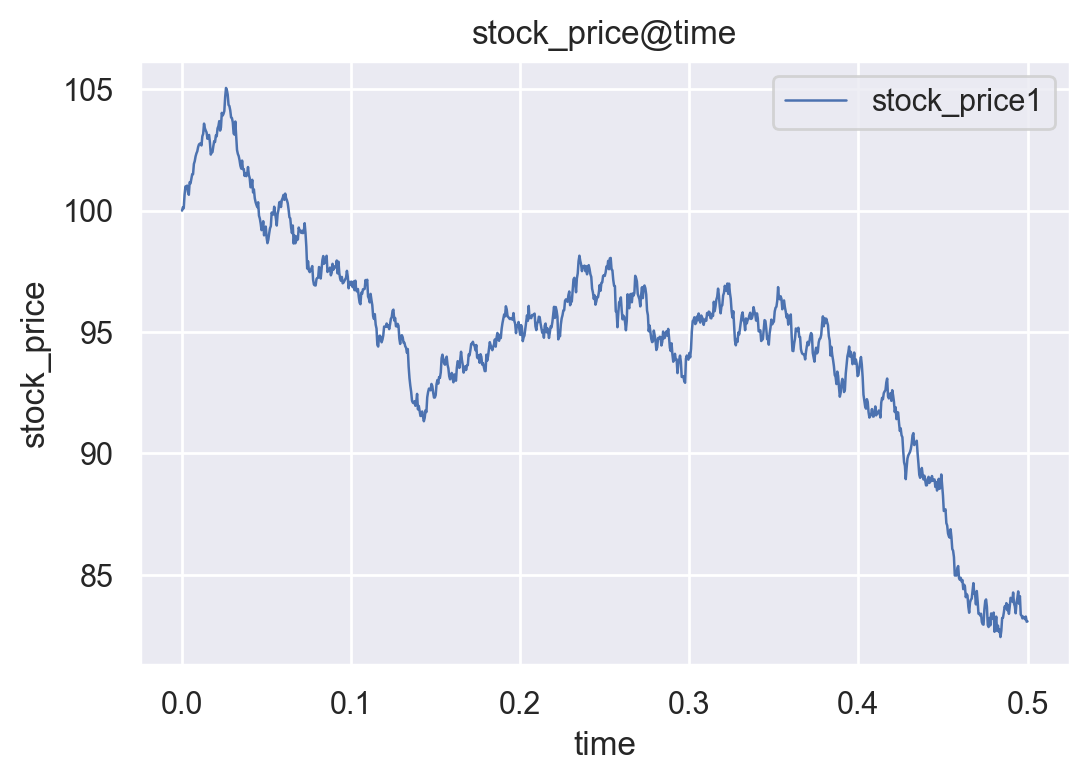

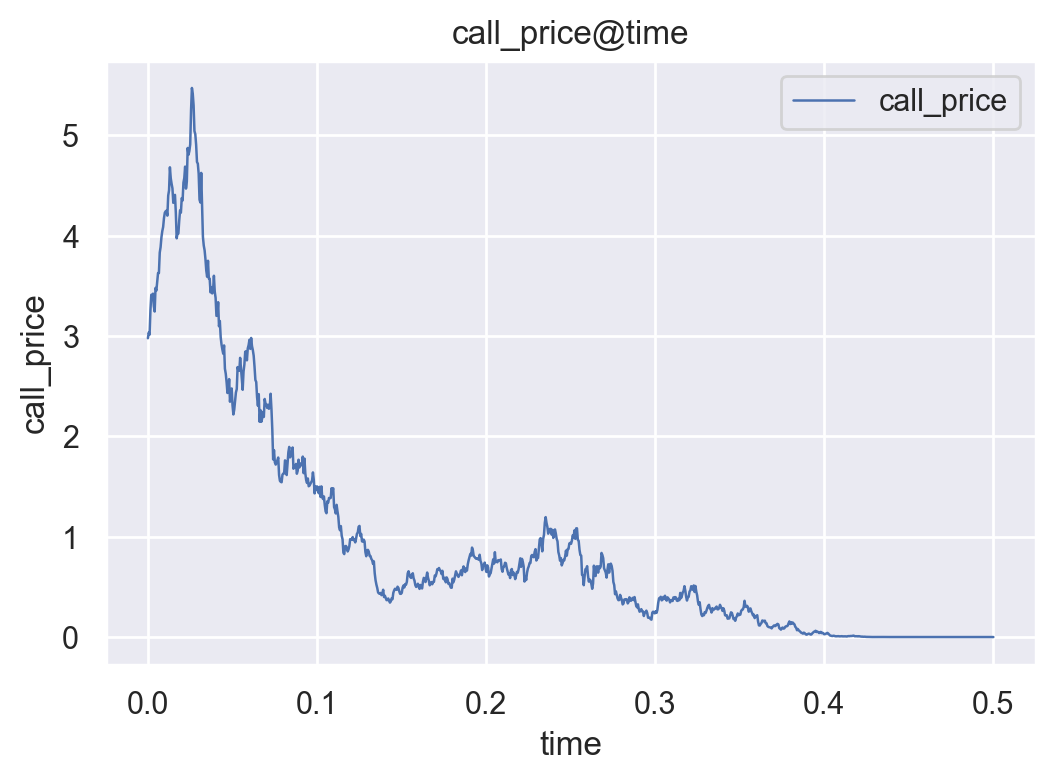

In [225]:
S0=100
T = 1/2
N = 1000
r=0.05
K = 105

# sumulate stock price with 
path = St_simulation_SDE(S0, T, N, r)
paths = []
paths.append(path)
names = ['stock_price1']
xname = 'time'
yname = 'stock_price'
plot_path(paths, names, T, xname, yname)

# call price
Ct_path, Deltas, Deltas_dis = Ct_value(path, K, T, N)
paths = []
paths.append(Ct_path)
names = ['call_price']
xname = 'time'
yname = 'call_price'
plot_path(paths, names, T, xname, yname)

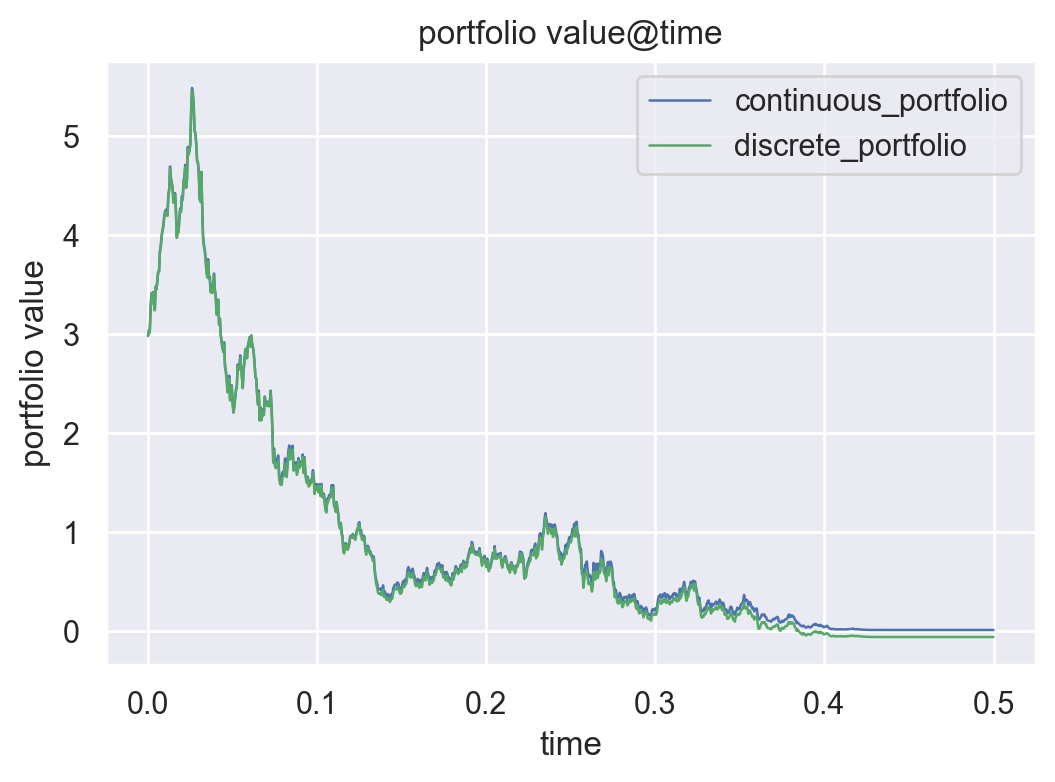

In [226]:
# continuous hedging portfolio
vals = continous_value(path, Deltas, Ct_path, r, T, N)
discrete_vals = continous_value(path, Deltas_dis, Ct_path, r, T, N)
paths = []
paths.append(vals)
paths.append(discrete_vals)
names = ['continuous_portfolio', 'discrete_portfolio']
xname = 'time'
yname = 'portfolio value'
plot_path(paths, names, T, xname, yname)

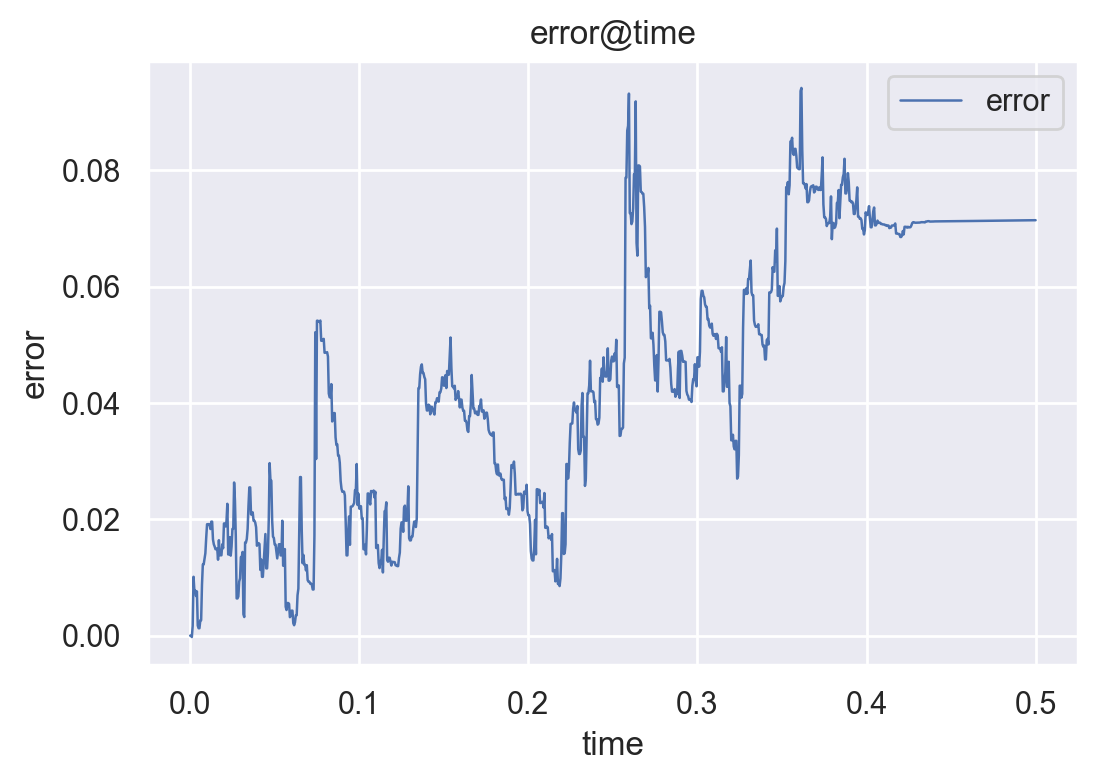

In [227]:
error = (np.array(vals)-np.array(discrete_vals)).tolist()
paths = []
paths.append(error)
names = ['error']
xname = 'time'
yname = 'error'
plot_path(paths, names, T, xname, yname)

In [231]:
S0=100
T = 1/2
N = 1000
r=0.05
K = 105
error = []
for i in range(1000):
    # sumulate stock price with 
    path = St_simulation_SDE(S0, T, N, r)
    # call price
    Ct_path, Deltas, Deltas_dis = Ct_value(path, K, T, N)
    # continuous hedging portfolio
    vals = continous_value(path, Deltas, Ct_path, r, T, N)
    discrete_vals = continous_value(path, Deltas_dis, Ct_path, r, T, N)
    error_i = (np.array(vals)-np.array(discrete_vals)).tolist()
    error += error_i

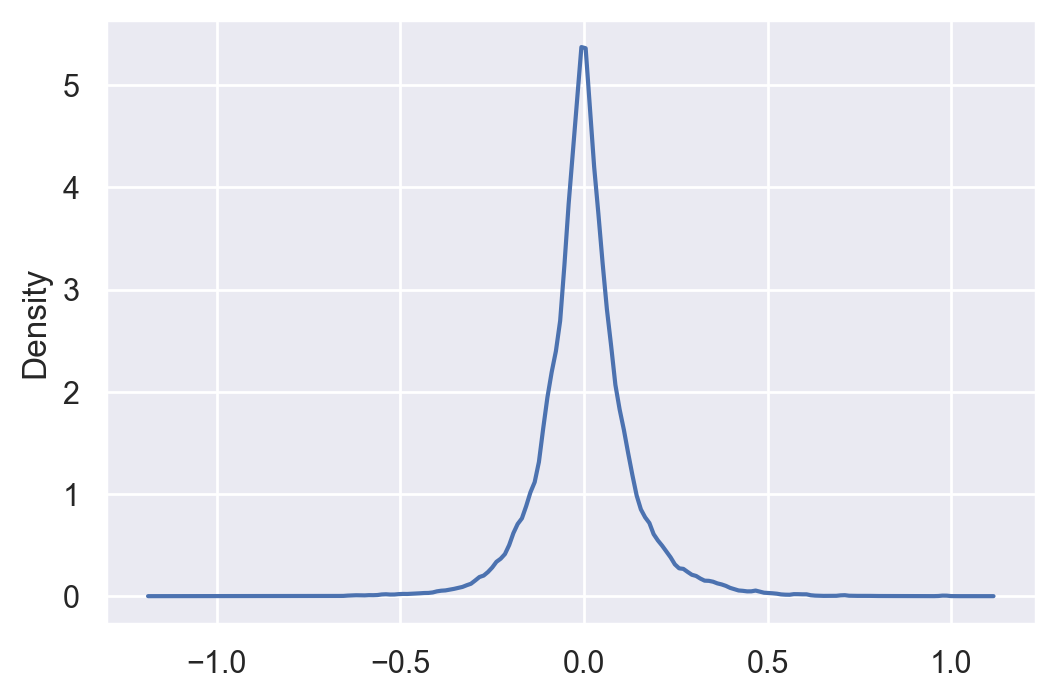

In [232]:
sns.kdeplot(error)